In [5]:
%%capture
!unzip "flowers.zip" -d "data/"

In [6]:
from typing import Tuple, Dict, List

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import random

In [7]:
def create_model(num_classes: int) -> nn.Module:
    # Loading the pre-trained ViT-B-16 model
    model = torchvision.models.vit_b_16(
        weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1
    )

    # Freeze most parameters to prevent overfitting
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last layer of encoder and classification headers
    for param in model.encoder.layers[-1].parameters():
        param.requires_grad = True

    # Replacement of classification headers
    in_features = model.heads.head.in_features
    model.heads = nn.Sequential(
        nn.LayerNorm(in_features),
        nn.Linear(in_features, 512),
        nn.GELU(),
        nn.Dropout(0.1),
        nn.Linear(512, num_classes)
    )

    return model


def create_dataloaders(
    data_dir: str,
    batch_size: int = 32
) -> Tuple[DataLoader, DataLoader, int]:
    # Training set data enhancement
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224), # Adjustment to 224x224
        transforms.RandomHorizontalFlip(), # Random Horizontal Flip
        transforms.RandomRotation(20), # random rotation
        transforms.RandomAffine(10), # stochastic affine transformation
        transforms.ColorJitter(brightness=0.2, contrast=0.2), # Randomize brightness and contrast
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    # Validation set transformations
    val_transforms = transforms.Compose([
        transforms.Resize(256), # Resize the image to 256
        transforms.CenterCrop(224), # Cropped from center to 224x224
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    # Load dataset
    train_dataset = datasets.ImageFolder(
        root=f"{data_dir}/train",
        transform=train_transforms
    )

    val_dataset = datasets.ImageFolder(
        root=f"{data_dir}/validation",
        transform=val_transforms
    )

    # Get the number of categories
    num_classes = len(train_dataset.classes)

    # Create the data loader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True, # confuse data
        num_workers=2, # Load data using 2 sub-processes
        pin_memory=True # Speed up data loading by putting data into fixed memory
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    return train_loader, val_loader, num_classes


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 30,
    learning_rate: float = 1e-4,
    patience: int = 5,
    min_delta: float = 1e-4
) -> Dict[str, List[float]]:
    # Equipment selection
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Loss functions and optimisers
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learning_rate,
        weight_decay=0.01
    )

    # Record training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'train_accuracy': []
    }

    best_val_loss = float('inf')
    no_improvement_epochs = 0

    # Training cycles
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            i, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # Storage indicators
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epohce: [{epoch+1}/{num_epochs}]')
        print(f'training loss: {train_loss:.4f}')
        print(f'validation loss: {val_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')
        print('-' * 50)

        # Early Stop Mechanism
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= patience:
            print(f'Early stop triggered at round {epoch+1}')
            break

    return history


def plot_training_history(history: Dict[str, List[float]]):

    plt.figure(figsize=(15,5))

    # lossy subplot
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='training loss')
    plt.plot(history['val_loss'], label='validation loss')
    plt.title('loss curve')
    plt.xlabel('epoche')
    plt.ylabel('loss')
    plt.legend()

    # Accuracy Subplot
    plt.subplot(1,2,2)
    plt.ylim((60, 100))
    plt.plot(history['val_accuracy'], label='Verification of accuracy')
    plt.title('Accuracy curve')
    plt.xlabel('epoche')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


def visualize_predictions(
    model: nn.Module,
    val_loader: DataLoader,
    class_names: List[str],
    num_samples: int = 5
):

    device = next(model.parameters()).device
    model.eval()

    # Collection of all forecasts
    all_images = []
    all_labels = []
    all_predictions = []
    all_confidences = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            confidences = torch.softmax(outputs, dim=1)
            max_confidences, predicted = torch.max(confidences, 1)

            for img, label, pred, conf in zip(images, labels, predicted, max_confidences):
                all_images.append(img)
                all_labels.append(label)
                all_predictions.append(pred)
                all_confidences.append(conf)

    # randomly selected sample
    selected_indices = random.sample(range(len(all_images)), num_samples)

    # Preparing the drawing
    num_images = len(selected_indices)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))


    for i, idx in enumerate(selected_indices):
        img = all_images[idx].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        # Setting the title and colours
        confidence = all_confidences[idx].item() * 100
        is_correct = all_labels[idx] == all_predictions[idx]

        if is_correct:
            title_color = 'green'
            title = (f'Correct - predicted: {class_names[all_predictions[idx]]}\n'
                     f'actual: {class_names[all_labels[idx]]}\n'
                     f'confidence: {confidence:.2f}%')
        else:
            title_color = 'red'
            title = (f'Error - prediction: {class_names[all_predictions[idx]]}\n'
                     f'actual: {class_names[all_labels[idx]]}\n'
                     f'confidence: {confidence:.2f}%')

        axes[i].imshow(img)
        axes[i].set_title(title, color=title_color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

Epohce: [1/30]
training loss: 0.4676
validation loss: 0.3690
Validation Accuracy: 87.40%
--------------------------------------------------
Epohce: [2/30]
training loss: 0.2432
validation loss: 0.3923
Validation Accuracy: 86.59%
--------------------------------------------------
Epohce: [3/30]
training loss: 0.2024
validation loss: 0.3461
Validation Accuracy: 88.44%
--------------------------------------------------
Epohce: [4/30]
training loss: 0.1717
validation loss: 0.3328
Validation Accuracy: 89.60%
--------------------------------------------------
Epohce: [5/30]
training loss: 0.1468
validation loss: 0.4791
Validation Accuracy: 84.39%
--------------------------------------------------
Epohce: [6/30]
training loss: 0.1298
validation loss: 0.3667
Validation Accuracy: 89.13%
--------------------------------------------------
Epohce: [7/30]
training loss: 0.1234
validation loss: 0.3933
Validation Accuracy: 88.44%
--------------------------------------------------
Epohce: [8/30]
train

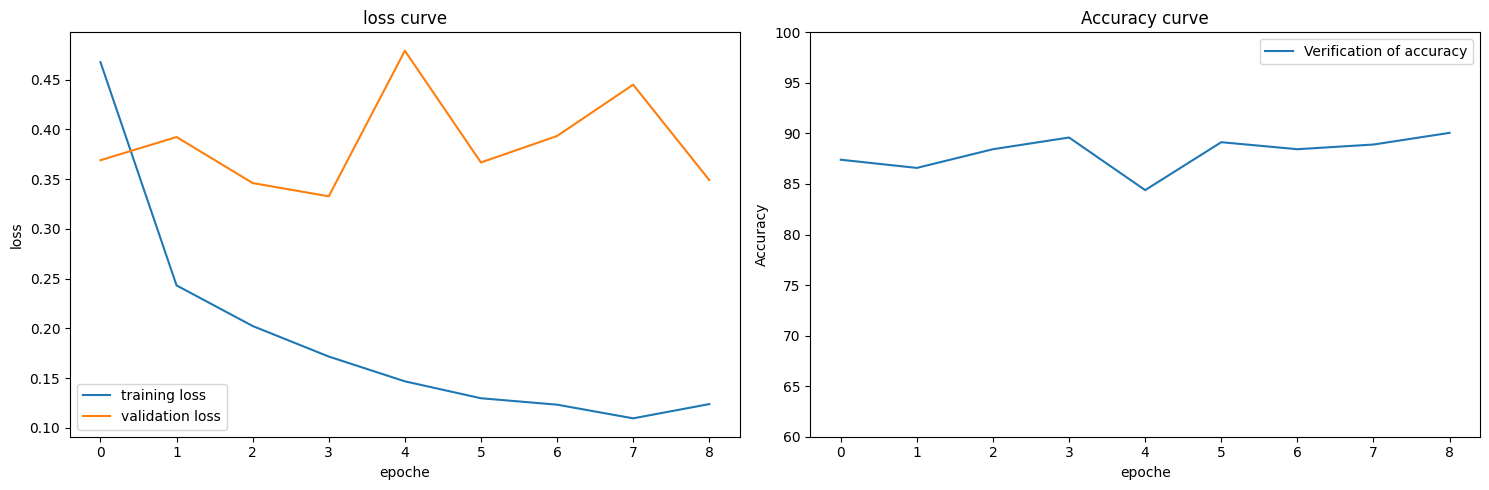

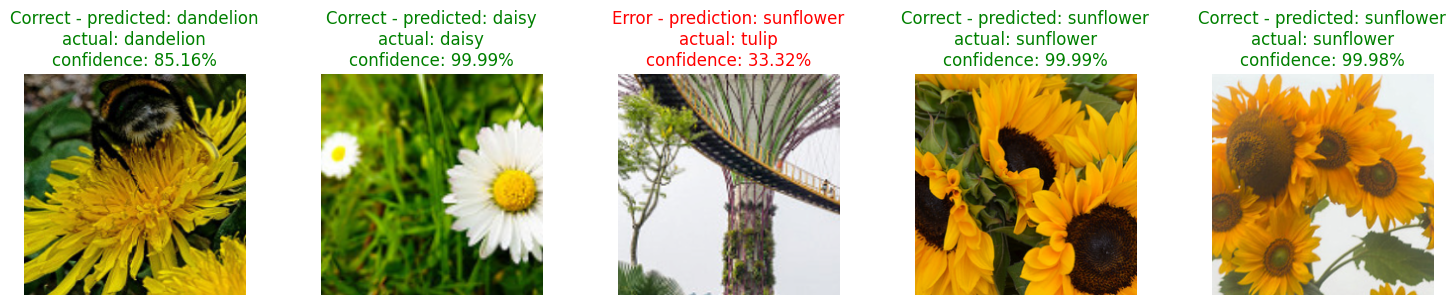

In [8]:
# Data catalogue
data_dir = "data/pic"

# Creating a Data Loader
train_loader, val_loader, num_classes = create_dataloaders(
    data_dir=data_dir,
    batch_size=16
)

model = create_model(num_classes=num_classes)

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=30,
    learning_rate=1e-4
)

# Mapping training history
plot_training_history(history)

# Visualisation of predicted results
class_names = train_loader.dataset.classes
visualize_predictions(
    model=model,
    val_loader=val_loader,
    class_names=class_names,
    num_samples=5
)